In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from models.model import ConNet, Rectifiedflow
from train.train_rectified_flow import train_rectified_flow
from sklearn.model_selection import train_test_split

In [ ]:
#Cargamos los datos:
path_pi_0 = r"C:\Users\gilda\Desktop\VS\Python\Flujo Rectificado Propuesta\dataset\noise_subset_500.npy"
path_pi_1 = r"C:\Users\gilda\Desktop\VS\Python\Flujo Rectificado Propuesta\dataset\cartoon_subset_500.npy"

pi_0= np.load(path_pi_0)  # shape: (N, C, H, W)
pi_1 = np.load(path_pi_1)  # shape: (N, C, H, W)

# Separamos entre entrenamiento y validación
pi0_train, pi0_val, pi1_train, pi1_val = train_test_split(
    pi_0, pi_1, test_size=0.2, random_state=42
)

In [ ]:
# Convierte a tensores y cambia el orden a (N, C, H, W)
# Utilizamos los datos de validación para probar el modelo
x0_val = torch.tensor(pi0_val, dtype=torch.float32).permute(0,3,1,2)
x1_val = torch.tensor(pi1_val, dtype=torch.float32).permute(0,3,1,2)


# 1-Rectified Flow

cargamos el modelo entrenado

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ConNet().to(device)
model.load_state_dict(torch.load("rectifiedflow_model.pth", map_location=device))
model.eval()
rectified_flow = Rectifiedflow(model=model, num_steps=100)

Generar una imágen

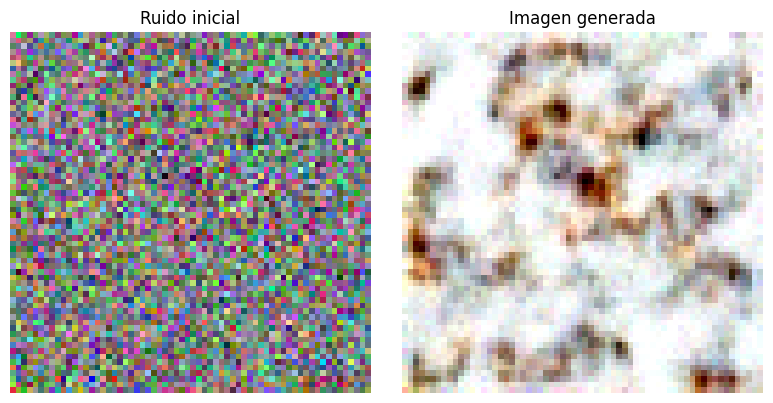

In [ ]:

# Elegimos un batch de validación
z0 = x0_val[0:1].to(device)  # primer ejemplo de validación

with torch.no_grad():
    traj = rectified_flow.sample_ode(z0)

# 4. Visualización
original_noise = z0.squeeze().cpu().permute(1, 2, 0).numpy()
generated_img = traj[-1].squeeze().cpu().permute(1, 2, 0).numpy()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.clip(original_noise, 0, 1))
axs[0].set_title("Ruido inicial")
axs[0].axis('off')

axs[1].imshow(np.clip(generated_img, 0, 1))
axs[1].set_title("Imagen generada")
axs[1].axis('off')

plt.tight_layout()
#plt.savefig("inference_result.png")
plt.show()

creación de gif


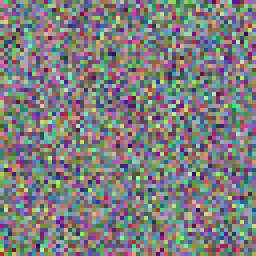

In [32]:
import imageio
import cv2

# Genera la trayectoria desde ruido
z0 = x0[2:3].to(device)  # Batch de 1 imagen
with torch.no_grad():
    traj = rectified_flow.sample_ode(z0)
# Define el nuevo tamaño (por ejemplo, 256x256)
new_size = (256, 256)
# Convierte cada paso a imagen y guarda los frames
frames = []
for step_img in traj:
    img = step_img.squeeze().cpu().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    img = cv2.resize(img, new_size, interpolation=cv2.INTER_NEAREST)
    frames.append(img)

# Guarda el GIF
imageio.mimsave('evolucion_rectifiedflow.gif', frames, duration=0.3)

# Visualiza el GIF en la notebook
from IPython.display import Image
Image(filename='evolucion_rectifiedflow.gif')

# 2-Rectified Flow

cargamos el modelo

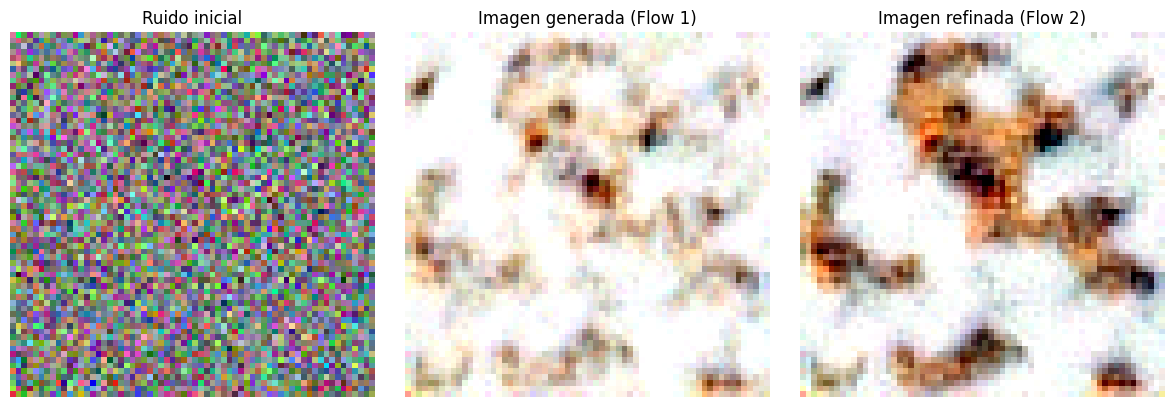

In [33]:
# Cargar el segundo modelo entrenado
model2 = ConNet().to(device)
model2.load_state_dict(torch.load("rectifiedflow2_model.pth", map_location=device))
model2.eval()
rectified_flow2 = Rectifiedflow(model=model2, num_steps=100)

# 1. Genera imagen con el primer modelo (ya lo tienes en traj[-1])
z0 = x0[2:3].to(device)
with torch.no_grad():
    traj1 = rectified_flow.sample_ode(z0)
    x1_hat = traj1[-1].to(device)  # Imagen generada por el primer modelo

# 2. Refinar con el segundo modelo
with torch.no_grad():
    traj2 = rectified_flow2.sample_ode(x1_hat)

# 3. Visualización
refined_img = traj2[-1].squeeze().cpu().permute(1, 2, 0).numpy()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(np.clip(z0.squeeze().cpu().permute(1, 2, 0).numpy(), 0, 1))
axs[0].set_title("Ruido inicial")
axs[0].axis('off')

axs[1].imshow(np.clip(x1_hat.squeeze().cpu().permute(1, 2, 0).numpy(), 0, 1))
axs[1].set_title("Imagen generada (Flow 1)")
axs[1].axis('off')

axs[2].imshow(np.clip(refined_img, 0, 1))
axs[2].set_title("Imagen refinada (Flow 2)")
axs[2].axis('off')

plt.tight_layout()
plt.show()